In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:
@jit(nopython = True)
def RK4_2nd(d2ydt2, ti, tf,vi, yi, h):
    t = np.arange(ti, tf+h, h)
    y, v = 0*t, 0*t
    v[0], y[0] = vi, yi
    # y'' = f(x, y, y')
    # y' = g(x, y) = u
    # u' = f(x, y, u)
    # y' = g(x, y, u) = u
    F = lambda x, y, u: np.array([d2ydt2(x, y, u), u])
    for i in range(1, len(t)):
        k1 = F(t[i-1], y[i-1], v[i-1])
        k2 = F(t[i-1]+h/2, y[i-1]+k1[1]*h/2, v[i-1]+k1[0]*h/2)
        k3 = F(t[i-1]+h/2, y[i-1]+k2[1]*h/2, v[i-1]+k2[0]*h/2)
        k4 = F(t[i-1]+h, y[i-1]+k3[1]*h, v[i-1]+k3[0]*h)
        v[i], y[i] = np.array([v[i-1], y[i-1]]) + h/6*(k1+2*k2+2*k3+k4)
    return y, v

In [3]:
def pot(x, x01, x02, D0=50.5, a1=1.0, a2=1.0, coup=1.0):
    v1 = D0 * (1 - np.exp(-a1 * (x - x01)))**2
    f1 = 2 * D0 * (1 - np.exp(-a1 * (x - x01))) * np.exp(-a1 * (x - x01)) * a1

    v2 = D0 * (1 - np.exp(a2 * (x - x02)))**2
    f2 = -2 * D0 * (1 - np.exp(a2 * (x - x02))) * np.exp(a2 * (x - x02)) * a2

    diff = (v1 - v2) / np.sqrt((v1 - v2)**2 + 4 * coup**2)

    c1 = 1 / np.sqrt(2) * np.sqrt(1 - diff)
    c2 = 1 / np.sqrt(2) * np.sqrt(1 + diff)

    e1 = 0.5 * ((v1 + v2) - np.sqrt((v1 - v2)**2 + 4 * coup**2))
    g0 = c1**2 * f1 + c2**2 * f2

    return v1, v2, e1, f1, f2, g0

@jit(nopython=True)
def U(x):
    # v1, v2, e1, f1, f2, g0 = pot(x, -0.5, 0.5)
    D0, D1, a1, a2, x01, x02, coup = 150, 150, 6.0, 3.0, -0.25, 0.25, 2.0
    v1 = D0 * (1 - np.exp(-a1 * (x - x01)))**2
    v2 = D1 * (1 - np.exp(a2 * (x - x02)))**2
    return 0.5*((v1 + v2) - np.sqrt((v1 - v2)**2 + 4 * coup**2))

In [5]:
%matplotlib qt

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


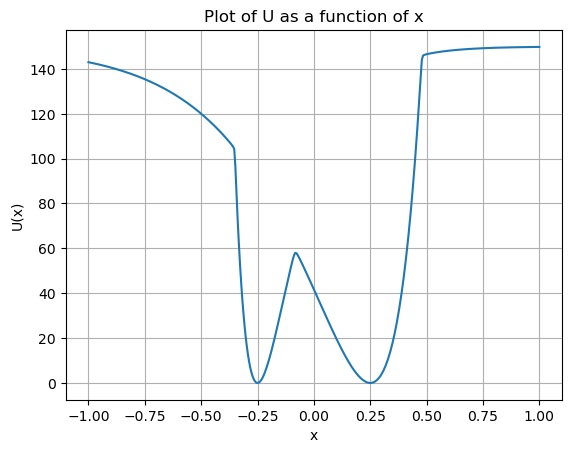

In [4]:
x_values = np.linspace(-1, 1, 400)
U_values = np.array([U(x) for x in x_values])
plt.plot(x_values, U_values)
plt.xlabel('x')
plt.ylabel('U(x)')
plt.title('Plot of U as a function of x')
plt.grid(True)
plt.show()

In [5]:
def solve_langevin(U, lamda, sigma, N, t, x0=0, v0=0, a=None, dx = 0.01, reflective=True):
    dt = t[1] - t[0]
    # Random terms for stochastic dynamics
    noise_term = sigma*np.random.randn(len(t))/np.sqrt(dt)
    
    # Initial conditions
    pos = [x0]
    # vel = [2 * v0 * np.random.random(N) - v0]
    vel = [v0]
    
    # Runge-Kutta 4th Order Implementation
    for i, noise in enumerate(noise_term):
        xs = pos[-1]
        vxs = vel[-1]
        
        # Define total acceleration
        def acceleration(t, x, v):
            drag = -lamda * v
            force = -(U(x + dx) - U(x - dx)) / (2 * dx)
            return drag + force + noise
        
        # vector form of the differential equation
        F = lambda t, r: np.array([r[1], acceleration(t, r[0], r[1])])
        
        # runge kutta coef.
        r = np.array([pos[-1], vel[-1]])
        k1 = F(t[i-1], r)
        k2 = F(t[i-1]+dt/2, r+k1*dt/2)
        k3 = F(t[i-1]+dt/2, r+k2*dt/2)
        k4 = F(t[i-1]+dt, r+k3*dt)
        
        xs, vxs = r + dt/6*(k1+2*k2+2*k3+k4)
        
        # Boundary conditions: reflecting BC
        if reflective is True:
            if xs > a:
                vxs *= -1
                xs = 2 * a - xs
            if xs < -a:
                vxs *= -1
                xs = -2 * a - xs
        
        pos.append(xs)
        vel.append(vxs)
    vel = np.array(vel)
    pos = np.array(pos)
    return pos, vel

In [6]:
def langevin_step(U, lamda, sigma, dt, x0=0, v0=0, dx = 0.01):
    # Random terms for stochastic dynamics
    if type(x0) == np.ndarray:
        noise_term = sigma*np.random.randn(len(x0))/np.sqrt(dt)
    else:
        noise_term = sigma*np.random.randn()/np.sqrt(dt)
    
    # Initial conditions
    pos = x0
    vel = v0
    
    # Runge-Kutta 4th Order Implementation
    
    # # Define total acceleration
    # def acceleration(t, x, v):
    #     drag = -lamda * v
    #     force = -(U(x + dx) - U(x - dx)) / (2 * dx)
    #     return drag + force + noise_term
    
    # # vector form of the differential equation
    # F = lambda t, r: np.array([r[1], acceleration(t, r[0], r[1])])
    
    # runge kutta coef.
    r = np.array([pos, vel])
    k1 = np.array([r[1], -lamda*r[1] - (U(r[0] + dx) - U(r[0]-dx))/(2*dx) + noise_term])#F(0.0, r)
    r2 = r + k1*dt/2
    k2 = np.array([r2[1], -lamda*r2[1] - (U(r2[0] + dx) - U(r2[0]-dx))/(2*dx) + noise_term])#F(0.0+dt/2, r+k1*dt/2)
    r3 = r + k2*dt/2
    k3 = np.array([r3[1], -lamda*r3[1] - (U(r3[0] + dx) - U(r3[0]-dx))/(2*dx) + noise_term])#F(0.0+dt/2, r+k2*dt/2)
    r4 = r + k3*dt
    k4 = np.array([r4[1], -lamda*r4[1] - (U(r4[0] + dx) - U(r4[0]-dx))/(2*dx) + noise_term])#F(0.0+dt, r+k3*dt)
    r  = r + dt/6*(k1+2*k2+2*k3+k4)
    pos, vel = r
    return pos, vel

In [7]:
temp = 5*2.2#0.75
damp = 10
dt = 1e-2
M = 100000
t = np.arange(0, (M + 1)*dt, dt)


In [10]:
pos, _ = solve_langevin(U, lamda=damp, sigma=np.sqrt(2*temp*damp), a=None, N=1, t=t, x0=0.2, dx=1e-3, reflective=False)

In [11]:
len(pos)

100002

In [12]:
x_t = []
v_t = []
x0, v0 = 0,0
for i in range(M):
    x0, v0 = langevin_step(U, damp, np.sqrt(2*temp*damp), dt, x0, v0, dx=0.1)
    x_t.append(x0)
    v_t.append(v0)

In [8]:

x0, v0 = np.array([0, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 0])

def find_t_corr(x_0, v_0, num_replica, U, damp, temp, max_iter = 1000000, plot=False):
    x0 = x_0*np.ones(num_replica)
    v0 = v_0*np.ones(num_replica)
    poss = []
    vs = []
    corr = 1.0
    corrs = []
    i = 0
    while abs(corr) > 0.1 and i < max_iter:
        i += 1
        x1, v1 = langevin_step(U, damp, np.sqrt(2*temp*damp), dt, x0, v0, dx=0.1)
        poss.append(x1)
        vs.append(v1)
        if len(poss) > 5:
            corr = np.max(np.abs(np.corrcoef(np.transpose(poss)) - np.identity(len(poss[0]))))
            corrs.append(corr)
    if plot:
        plt.plot(corrs)
        plt.xlabel('Iteration')
        plt.ylabel('Correlation')
        plt.title('Correlation over Iterations')
        plt.legend(['Correlation'])
        plt.grid(True)
        plt.show()
    return i*dt, poss[-1], vs[-1]

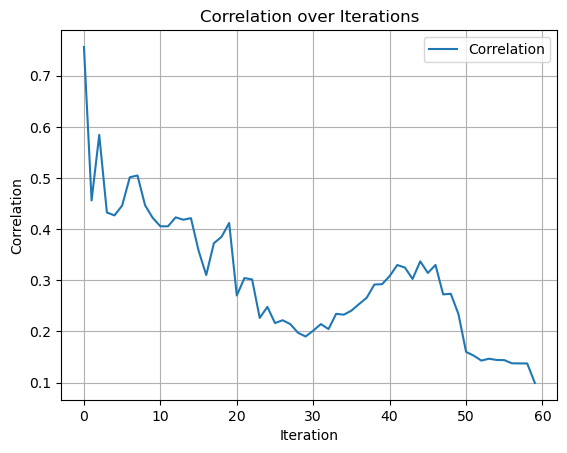

(0.65,
 array([0.01927786, 0.00599107, 0.00759891, 0.00076558, 0.00166482]),
 array([3.86686158, 1.20656737, 1.53008606, 0.15425234, 0.33541382]))

In [9]:
find_t_corr(0, 0, 5, U, damp, temp, plot=True)

In [14]:
def parallel_replica(U, num_replicas, dt, x_initial, characteristic, max_iter = 1000000, t_cor = None):
    # characteristic: the characteristic function, identifying when the system is in the tapped state
    damp_coef = 10
    temp = 2.2*5
    # initial_positions = 
    x_0 = x_initial
    v_0 = 0
    
    # make num_replicas replicas
    x_arr0 = np.array(num_replicas*[x_0])
    v_arr0 = np.array(num_replicas*[v_0])
    
    if t_cor is None: 
        # here should go a calculate t_corr funciton
        t_cor, x_arr0, v_arr0 = find_t_corr(x_arr0, v_arr0, num_replicas, U, damp_coef, temp)
        # raise(RuntimeError("I still have not yet made a function to calculate the correlation time"))
    else:
        for i in int(t_cor/dt):
            x_arr0, v_arr0 = langevin_step(U, damp_coef, np.sqrt(2*temp*damp_coef), dt, x_arr0, v_arr0)
    
    x_arr = x_arr0
    v_arr = v_arr0
    stop = 0
    for i in range(max_iter): 
        x_arr, v_arr = langevin_step(U, damp_coef, np.sqrt(2*temp*damp_coef), dt, x_arr, v_arr)
        if not any(characteristic(y) for y in x_arr):
            stop += 1
        else:
            stop = 0
        if stop > 5:
            return i*dt, t_cor, 1/i/dt/num_replicas
    return -1, t_cor, float('inf')

In [15]:
x_space = np.linspace(-0.3305, -0.079, 100)
char = lambda x: x_space[0]<=np.round(x, 2)<=x_space[-1]
parallel_replica(U, 5, dt, -0.2, characteristic=char)

(2715.77, 1.54, 7.364393891971705e-05)

In [42]:
pos, _ = solve_langevin(U, lamda=10, sigma=np.sqrt(2*2.2*10), a=None, N=1, t=t, x0=0.2, dx=1e-3, reflective=False)

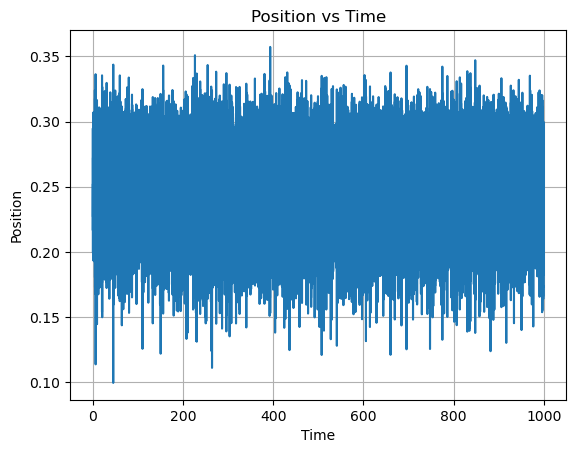

In [44]:
plt.plot(t, pos[:-1])
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position vs Time')
plt.grid(True)
plt.show()